In [1]:
import qdmpy
import qdmpy.pl
import qdmpy.plot
import qdmpy.field
import qdmpy.source

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# '%matplotlib widget' allows interactive plots in jupyterlab
# use ''%matplotlib inline' to allow export to pdf
# %matplotlib widget

In [3]:
exec(open('../TEST_DATA_PATH.py').read())

### Load raw data

In [4]:
options_dict = {
    "base_dir": TEST_DATA_PATH,
    "filepath": "T1_test/Spin relaxation (T1)_27",
    "custom_output_dir_suffix": "_{fit_backend}_bin_{total_bin}",
    "additional_bins": 2,
       
    "system_name": "Zyla",

    "ROI": "Full", 
    "ROI_start": [65, 30],
    "ROI_end": [209, 187],
    
    "AOI_1_start":  [40, 65],
    "AOI_1_end":    [50,  75], 
    "AOI_2_start":  [20, 100],
    "AOI_2_end":    [30, 110], 
    "single_pixel_check": [90//2, 150//2],
    
    "remove_start_sweep": 2,
    
    "show_tick_marks": True,
    
    "fit_backend": "cpufit",
    "fit_backend_comparison": ["cpufit", "scipyfit"],
    "fit_pl_pixels": True, 
    "force_fit": True, 
    
    "use_ROI_avg_fit_res_for_all_pixels": True,
    
    "scipyfit_sub_threads": 2, 

    "fit_functions":  {"constant": 1, "stretched_exponential": 1},
    
    "normalisation": "true_sub",
    
    "constant_guess": 0.0,
    "constant_bounds": [-0.1, 0.1],

    "power_exp_guess": 0.7,
    "power_exp_bounds": [0.0, 1.0],

    "charac_exp_t_guess": 10e-6,
    "charac_exp_t_bounds": [1e-6, 2e-5],

    "amp_exp_guess": 1.0,
    "amp_exp_bounds": [1e-4, 2.0],
        
    "save_fig_type": "png",
    
    "colormap_range_dicts": {
        "residual_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "sigma_images": {
            "type": "percentile",
            "values": [2, 98]
        },
        "param_images": {
            "type": "percentile",
            "values": [2, 98]
        },
    },
    "mpl_rcparams": {
        "legend.loc": "upper right",
    }
}

# if you want to use a reference experiment {ensure you run this even if 'None' as it sets up output dirs etc.}
ref_options_dir = None

In [5]:
options, ref_options = qdmpy.initialize(
    options_dict=options_dict,
    ref_options_dir=ref_options_dir,
    set_mpl_rcparams=True
)

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/shared/misc.py:17: QDMPYWarning: Continuing without reference. (No reference chosen or exp_referece_type was 'None')
  warnings.warn(msg, QDMPYWarning)


### Load data

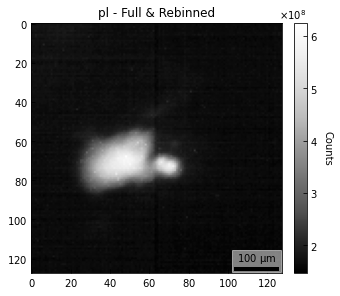

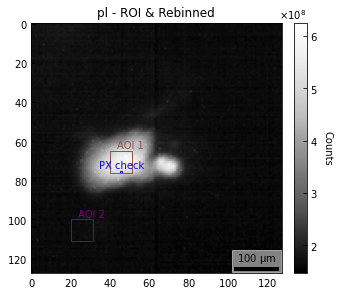

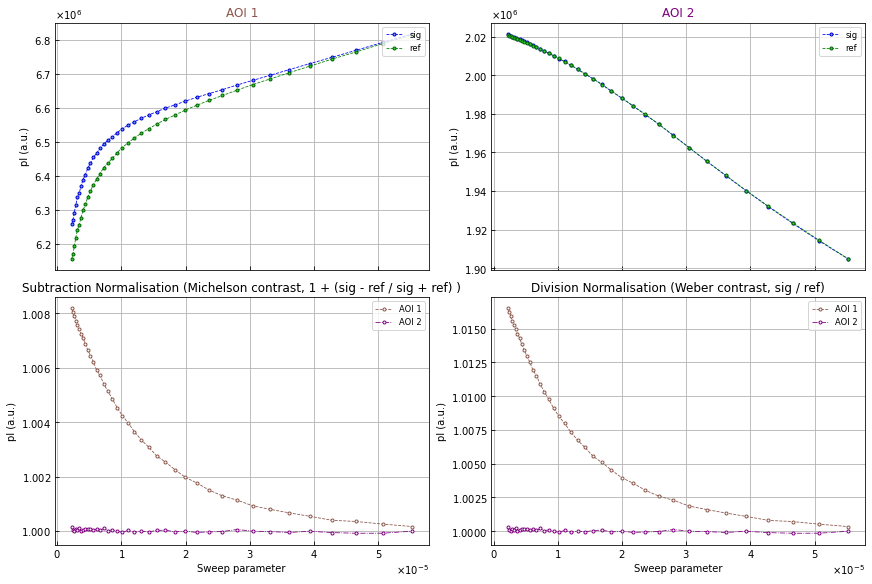

In [6]:
image, prelim_sweep_list = qdmpy.pl.load_image_and_sweep(options)
PL_image, PL_image_ROI, sig, ref, sig_norm, single_pixel_pl, sweep_list, ROI = qdmpy.pl.reshape_dataset(
        options, image, prelim_sweep_list
    )

ROI_PL_fig = qdmpy.plot.roi_pl_image(options, PL_image)

AOI_PL_fig = qdmpy.plot.aoi_pl_image(options, PL_image_ROI)

AOI_spectra_fig = qdmpy.plot.aoi_spectra(options, sig, ref, sweep_list)

qdmpy.pl.save_pl_data(options, PL_image, PL_image_ROI)

### Load reference experiment - note, you can fit in this same notebook!

In [7]:
# ref_fit_params, ref_sigmas = qdmpy.pl.load_ref_exp_pl_fit_results(ref_options)

### Fit AOI, ROI averages, single pixel

/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/pl/gpufit.py:167: UserWarning: CUDA error:
b'no CUDA-capable device is detected'
  warn(f"CUDA error:\n{gf.get_last_error()}")
/home/samsc/src/qs/qdmpy_proj/qdmpy_git/src/qdmpy/pl/scipyfit.py:35: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm  # auto detects jupyter


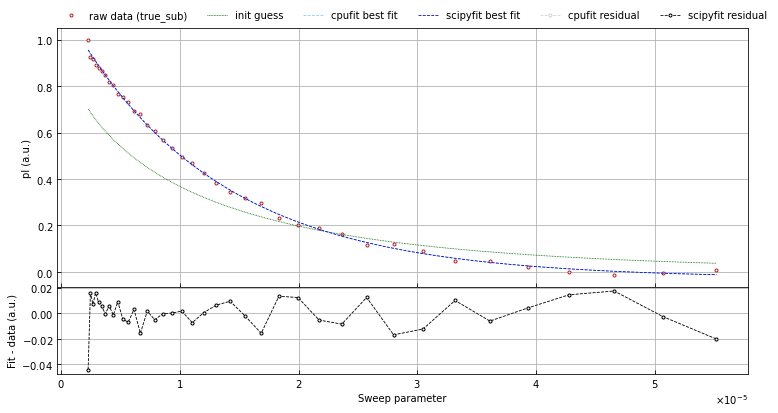

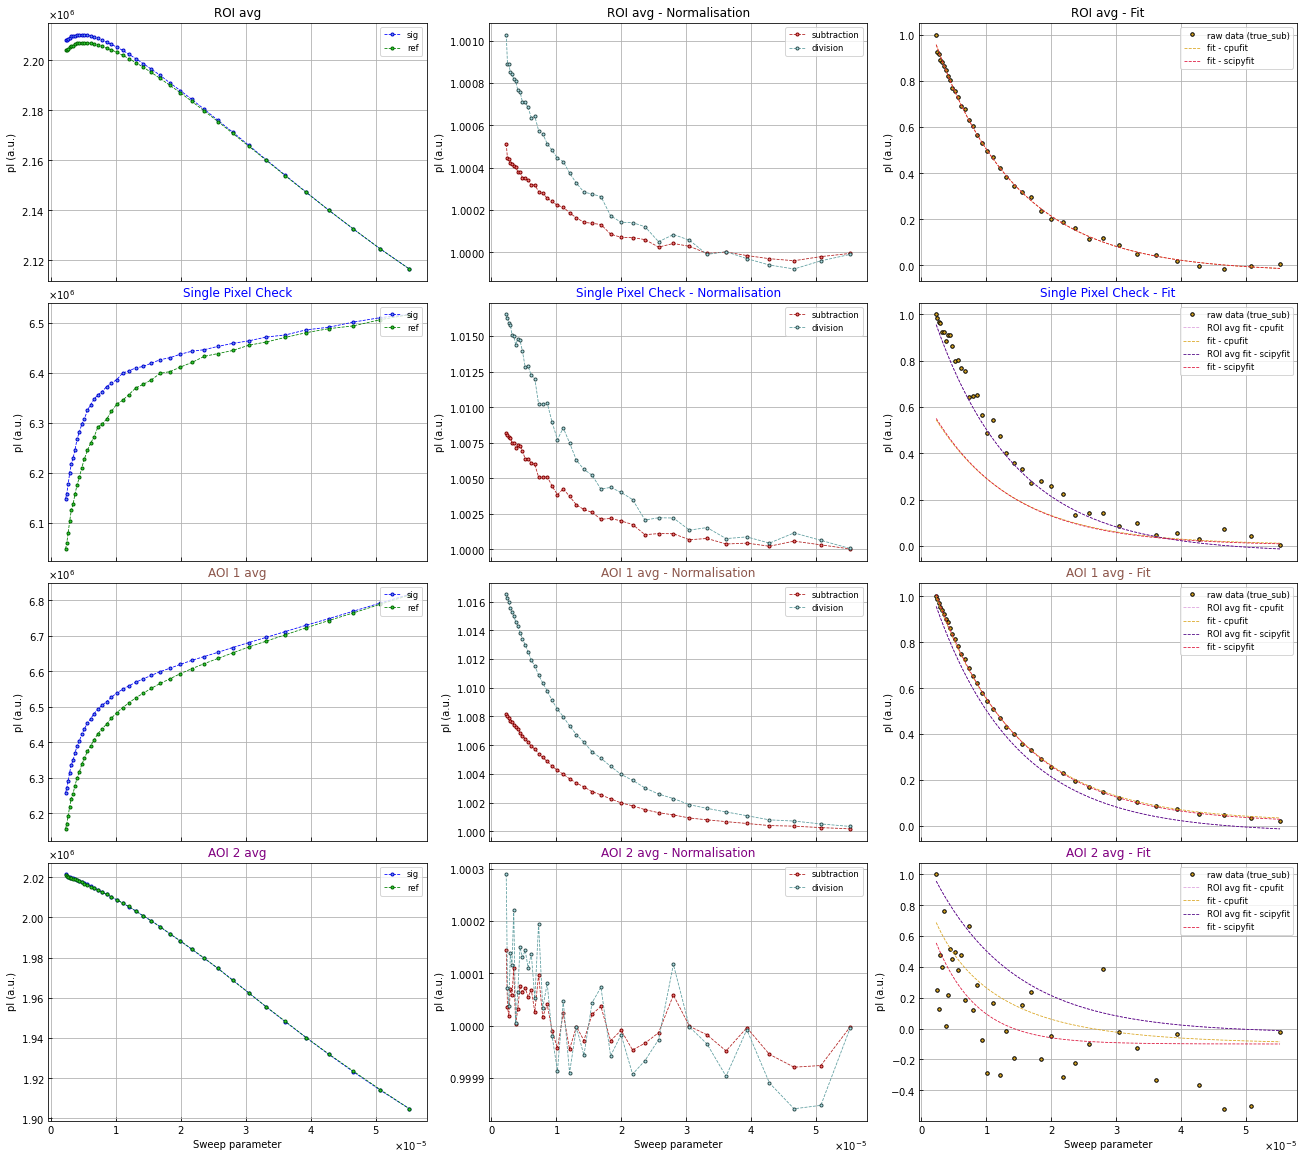

In [8]:
fit_model = qdmpy.pl.define_fit_model(options)
backend_ROI_results_lst = qdmpy.pl.fit_roi_avg_pl(options, sig, ref, sweep_list, fit_model) # if update sig_norm => sig,ref
ROI_fit_fig = qdmpy.plot.roi_avg_fits(options, backend_ROI_results_lst)

fit_result_collection_lst = qdmpy.pl.fit_aois_pl(options, sig, ref, single_pixel_pl, sweep_list, fit_model, backend_ROI_results_lst)
AOI_fit_fig = qdmpy.plot.aoi_spectra_fit(options, sig, ref, sweep_list, fit_result_collection_lst, fit_model)

### Fit pixels

In [9]:
wanted_roi_result = next(
    filter(
        lambda result: result.fit_backend == options["fit_backend"], backend_ROI_results_lst
    )
) # ROI fit result for chosen fit backend
pixel_fit_params, sigmas = qdmpy.pl.get_pl_fit_result(options, sig_norm, sweep_list, fit_model, wanted_roi_result)

qdmpy.pl.save_pl_fit_results(options, pixel_fit_params)
qdmpy.pl.save_pl_fit_sigmas(options, sigmas)

In [10]:
ref_fit_params, ref_sigmas = qdmpy.pl.load_ref_exp_pl_fit_results(ref_options)

### Plot (fit) parameters

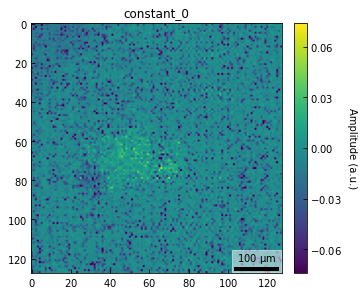

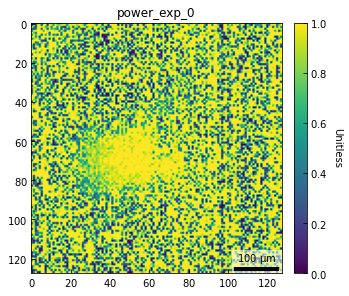

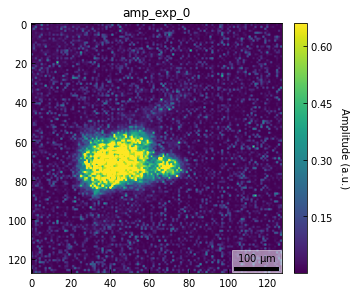

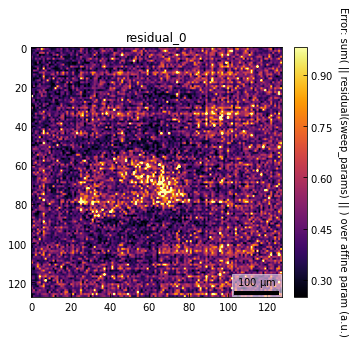

In [11]:
c_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "constant")
pow_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "power_exp")
amp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "amp_exp")
residual_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "residual")

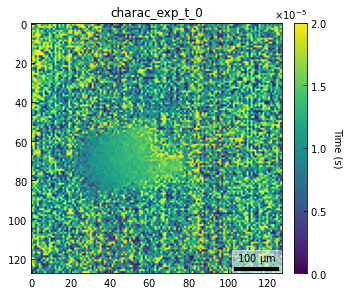

In [12]:
options["colormap_range_dicts"]["param_images"] = {
            "type": "strict_range",
            "values": [0, 20e-6],
}
exp_fig = qdmpy.plot.pl_param_images(options, fit_model, pixel_fit_params, "charac_exp_t")

In [13]:
qdmpy.save_options(options)
# import qdmpy.shared.json2dict; print(qdmpy.shared.json2dict.dict_to_json_str(options))